# Extract data from output files

### Code to extract timing information from output files of Lbann code
March 9, 2020

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import subprocess as sp
import os
import glob

## Extract training times

In [8]:
def f_get_output(fname):
    ''' Use grep to get run times from output files
    '''
    cmd='grep "run time" {0}| grep "training"'.format(fname)
    op1=sp.check_output(cmd,shell=True).decode('utf-8').split('\n')[:-1]
    # print(op1)

    cmd='grep "run time" {0}| grep "validation"'.format(fname)
    op2=sp.check_output(cmd,shell=True).decode('utf-8').split('\n')[:-1]
    
    return op1,op2

def f_get_run_times(op_arr):
    '''
    Get run times from output file out.log
    '''
    run_times=np.array([np.float(i.split(':')[-1][:-1]) for i in op_arr])
    return run_times

def f_print_run_times(fname):
    
    ### Get output 
    op1,op2=f_get_output(fname)
    ### Get arrays from outputs for training and validation
    arr1=f_get_run_times(op1)
    arr2=f_get_run_times(op2)
    ### Print times
    print("Training times: {0}\nValidation times: {1}".format(arr1,arr2))
    print("Number of epochs",len(arr1))
    print("Mean times:",np.mean(arr1),np.mean(arr2),'\n')
    


In [9]:

def f_store_run_times(fname):
    
    ### Get output 
    op1,op2=f_get_output(fname)
    ### Get arrays from outputs for training and validation
    arr1=f_get_run_times(op1)
    arr2=f_get_run_times(op2)
    ### Print times
    size=len(arr1) ### Number of epochs
    ### Compute mean and errors of times
    train_mean,train_err=np.mean(arr1),np.std(arr1)/np.sqrt(size)
    val_mean,val_err=np.mean(arr2),np.std(arr2)/np.sqrt(size)
    
    
    ### Extract processor info from the file name
    try:
        lst=fname.split('/')[-1].split('.')[0].split('_')
        nodes,procs,cpus=int(lst[1]),int(lst[2]),int(lst[3])
    except Exception as e:
        print(e,fle)
        nodes,procs,cpus=None,None,None
        pass
    
    job_strg='_'.join(fname.split('/')[-1].split('.')[0].split('-')[-1].split('_')[1:])
    
    keys=['train_arr','val_arr','train_mean','train_err','val_mean','val_err','num_epochs','nodes','GPUs_per_node','cpus','job_strg']
    values=[arr1,arr2,train_mean,train_err,val_mean,val_err,size,nodes,procs,cpus,job_strg]
    info_dict=dict(zip(keys,values))
    
#     print(info_dict)
    return info_dict


In [10]:
# fname=main_dir+'20200309_161923_exagan/out.log'
# f_store_run_times(fname)

In [11]:
# main_dir='/global/cfs/cdirs/m3363/vayyar/cosmogan_data/results_data/'
# for fldr in glob.glob(main_dir+'20200309_*'):
#     print(fldr.split('/')[-1])
#     fname=fldr+'/out.log'
#     f_print_run_times(fname)

In [13]:
main_dir='/global/cfs/cdirs/m3363/vayyar/cosmogan_data/results_data/20200318_131818_exagan/collected_outputs/'
main_dir='/global/cfs/cdirs/m3363/vayyar/cosmogan_data/results_data/20200327_102448_exagan/collected_outputs/'
df=pd.DataFrame([])

for fle in glob.glob(main_dir+'slurm-*_*.out'):
#     print(fle)
    info_dict=f_store_run_times(fle)
    df=df.append(info_dict,ignore_index=True)
    
df=df.sort_values(by=['nodes','GPUs_per_node']).reset_index(drop=True)
df

,GPUs_per_node,cpus,job_strg,nodes,num_epochs,train_arr,train_err,train_mean,val_arr,val_err,val_mean
0,1.0,4.0,1_1_4,1.0,44.0,"[128.278, 123.93, 120.289, 126.682, 118.146, 1...",5.206914,143.954091,"[12.0308, 11.9269, 12.1272, 12.2889, 11.8425, ...",0.630360,13.850602
1,6.0,4.0,1_6_4,1.0,50.0,"[24.1425, 21.3741, 20.9364, 23.347, 20.7767, 2...",0.164008,21.499262,"[2.45518, 2.40473, 2.33281, 2.2795, 1.85884, 2...",0.036657,2.235682
2,3.0,4.0,2_3_4,2.0,15.0,"[35.0176, 32.9311, 32.9584, 32.4283, 33.5589, ...",0.348965,33.202093,"[2.7057, 2.64797, 2.65958, 2.74747, 2.45336, 2...",0.020844,2.626582
3,2.0,4.0,3_2_4,3.0,50.0,"[35.494, 33.0734, 32.3848, 32.2004, 32.4618, 3...",0.284716,33.028820,"[2.75194, 2.68445, 2.64307, 2.64256, 2.57462, ...",0.012149,2.621958


In [15]:
col_list=['job_strg','GPUs_per_node','nodes','train_mean','train_err']
df[col_list]

,job_strg,GPUs_per_node,nodes,train_mean,train_err
0,1_1_4,1.0,1.0,143.954091,5.206914
1,1_6_4,6.0,1.0,21.499262,0.164008
2,2_3_4,3.0,2.0,33.202093,0.348965
3,3_2_4,2.0,3.0,33.028820,0.284716


Text(0.5, 1.0, 'Plot of Training time vs number of GPUs per node')

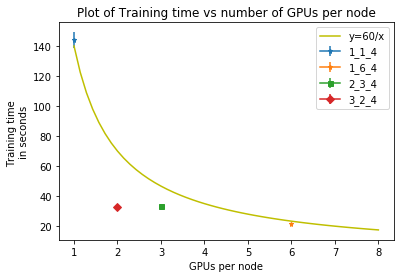

In [18]:
### Scaling plot 1
plt.figure()
for i,j in df.iterrows():
    x,y,yerr=j.GPUs_per_node,j.train_mean,j.train_err
    markers_dict={'1':'*','2':'s','3':'D','4':'h'}
    marker=markers_dict[str(int(j.nodes))]
    plt.errorbar(x=x,y=y,yerr=yerr,label=j.job_strg,markersize=5,marker=marker)
    
### Comparison with expected scaling
x=np.linspace(1,8,num=50)
plt.plot(x,140.0/x,color='y',label='y=60/x')
plt.xlabel('GPUs per node')
plt.ylabel('Training time \nin seconds')
plt.title('Plot of Training time vs number of GPUs per node')
plt.legend()
plt.title('Plot of Training time vs number of GPUs per node')

# plt.savefig('scalingplot1.png')

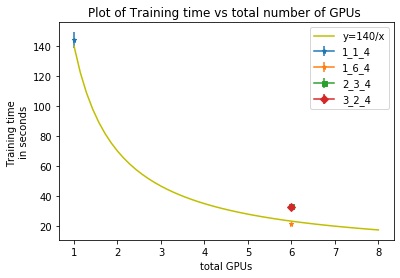

In [22]:
### Scaling plot 2
plt.figure()
for i,j in df.iterrows():
    x,y,yerr=j.GPUs_per_node*j.nodes,j.train_mean,j.train_err
    
    markers_dict={'1':'*','2':'s','3':'D','4':'h'}
    marker=markers_dict[str(int(j.nodes))]
    plt.errorbar(x=x,y=y,yerr=yerr,label=j.job_strg,markersize=5,marker=marker)
    
### Comparison with expected scaling
x=np.linspace(1,8,num=50)
plt.plot(x,60.0/x,color='y',label='y=60/x')
plt.xlabel('total GPUs')
plt.ylabel('Training time \nin seconds')
plt.title('Plot of Training time vs number of GPUs per node')
plt.legend()
plt.title('Plot of Training time vs total number of GPUs ')

plt.savefig('scalingplot2.png')

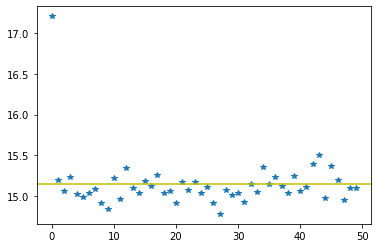

In [34]:
### Plot individual times
plt.figure()
y=df[df.job_strg=='1_4_4'].train_arr.values[0]
plt.plot(y,linestyle='',marker='*')
plt.axhline(np.mean(y),color='y')

### Scaling plots after doubling samples

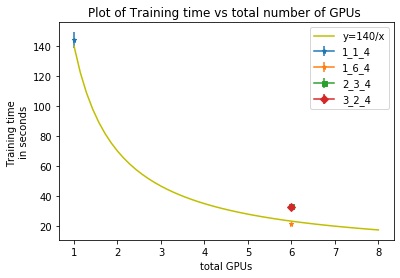

In [25]:
### Scaling plot 2
plt.figure()
for i,j in df.iterrows():
    x,y,yerr=j.GPUs_per_node*j.nodes,j.train_mean,j.train_err
    
    markers_dict={'1':'*','2':'s','3':'D','4':'h'}
    marker=markers_dict[str(int(j.nodes))]
    plt.errorbar(x=x,y=y,yerr=yerr,label=j.job_strg,markersize=5,marker=marker)
    
### Comparison with expected scaling
x=np.linspace(1,8,num=50)
plt.plot(x,140.0/x,color='y',label='y=140/x')
plt.xlabel('total GPUs')
plt.ylabel('Training time \nin seconds')
plt.title('Plot of Training time vs number of GPUs per node')
plt.legend()
plt.title('Plot of Training time vs total number of GPUs ')

plt.savefig('scalingplot3.png')